<a href="https://colab.research.google.com/github/arkhanks/Project_4_Machine_Learning/blob/main/workingupcolab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.5'
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [124]:
# imports
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import split, to_date
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, isnotnull


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [125]:
# Start Spark session
spark = SparkSession.builder.appName("RestaurantInspections").getOrCreate()

In [126]:
# Specify the file path to your local CSV file
file_path = '/content/ARCHIVED__Restaurant_Inspection_Scores__2016-2019__20250310.csv'  # Replace with your actual file path

# Read CSV file into Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame to verify it loaded correctly
df.show()

+-----------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+------------------+--------------------+---------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------------+-------------+-------------+---------------------+------------------------+----------------------------+----------------------+
|business_id|       business_name|    business_address|business_city|business_state|business_postal_code|business_latitude|business_longitude|   business_location|business_phone_number|  inspection_id|     inspection_date|inspection_score|     inspection_type|        violation_id|violation_description|risk_category|Neighborhoods|SF Find Neighborhoods|Current Police Districts|Current Supervisor Districts|Analysis Neighborhoods|
+-----------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+---------------

In [127]:
# Get the number of rows
num_rows = df.count()

# Print the result
print(f"Number of rows in the DataFrame: {num_rows}")

Number of rows in the DataFrame: 53973


In [128]:
df.printSchema()

root
 |-- business_id: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_address: string (nullable = true)
 |-- business_city: string (nullable = true)
 |-- business_state: string (nullable = true)
 |-- business_postal_code: string (nullable = true)
 |-- business_latitude: double (nullable = true)
 |-- business_longitude: double (nullable = true)
 |-- business_location: string (nullable = true)
 |-- business_phone_number: long (nullable = true)
 |-- inspection_id: string (nullable = true)
 |-- inspection_date: string (nullable = true)
 |-- inspection_score: integer (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- violation_id: string (nullable = true)
 |-- violation_description: string (nullable = true)
 |-- risk_category: string (nullable = true)
 |-- Neighborhoods: integer (nullable = true)
 |-- SF Find Neighborhoods: integer (nullable = true)
 |-- Current Police Districts: integer (nullable = true)
 |-- Current Supervisor Distr

In [129]:
df_drop=df.dropna()
df_drop.show()

+-----------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+------------------+--------------------+---------------------+--------------+--------------------+----------------+--------------------+--------------------+---------------------+-------------+-------------+---------------------+------------------------+----------------------------+----------------------+
|business_id|       business_name|    business_address|business_city|business_state|business_postal_code|business_latitude|business_longitude|   business_location|business_phone_number| inspection_id|     inspection_date|inspection_score|     inspection_type|        violation_id|violation_description|risk_category|Neighborhoods|SF Find Neighborhoods|Current Police Districts|Current Supervisor Districts|Analysis Neighborhoods|
+-----------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+-----------------

In [130]:
# Get the number of rows
num_rows = df_drop.count()

# Print the result
print(f"Number of rows in the DataFrame: {num_rows}")

Number of rows in the DataFrame: 5205


In [131]:
columns_to_remove = ["business_city", "business_state", "business_phone_number",
                     'business_location', 'Neighborhoods', 'SF Find Neighborhoods',
                     'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods']
                     # Get the list of existing columns to remove (checking if they exist in the DataFrame)
existing_columns_to_remove = [col for col in columns_to_remove if col in df.columns]
# Drop the columns that exist in the DataFrame
prepared_df = df_drop.drop(*existing_columns_to_remove)
prepared_df.show()

+-----------+--------------------+--------------------+--------------------+-----------------+------------------+--------------+--------------------+----------------+--------------------+--------------------+---------------------+-------------+
|business_id|       business_name|    business_address|business_postal_code|business_latitude|business_longitude| inspection_id|     inspection_date|inspection_score|     inspection_type|        violation_id|violation_description|risk_category|
+-----------+--------------------+--------------------+--------------------+-----------------+------------------+--------------+--------------------+----------------+--------------------+--------------------+---------------------+-------------+
|       3649|       SAFEWAY #1490|        2300 16th St|               94103|        37.765708|       -122.409002| 3649_20171206|12/06/2017 12:00:...|              82|Routine - Unsched...|3649_20171206_103131| Moderate risk ver...|Moderate Risk|
|        184|       

In [132]:
prepared_df.printSchema()

root
 |-- business_id: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_address: string (nullable = true)
 |-- business_postal_code: string (nullable = true)
 |-- business_latitude: double (nullable = true)
 |-- business_longitude: double (nullable = true)
 |-- inspection_id: string (nullable = true)
 |-- inspection_date: string (nullable = true)
 |-- inspection_score: integer (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- violation_id: string (nullable = true)
 |-- violation_description: string (nullable = true)
 |-- risk_category: string (nullable = true)



In [133]:
# Remove underscores and convert to integer
df_cleaned = prepared_df.withColumn("inspection_id", regexp_replace(col("inspection_id"), "_", "").cast("bigint")) \
               .withColumn("violation_id", regexp_replace(col("violation_id"), r"^[^_]*_[^_]*_", "").cast("bigint")
)

# Show Results
df_cleaned.show()



+-----------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+--------------------+----------------+--------------------+------------+---------------------+-------------+
|business_id|       business_name|    business_address|business_postal_code|business_latitude|business_longitude|inspection_id|     inspection_date|inspection_score|     inspection_type|violation_id|violation_description|risk_category|
+-----------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+--------------------+----------------+--------------------+------------+---------------------+-------------+
|       3649|       SAFEWAY #1490|        2300 16th St|               94103|        37.765708|       -122.409002| 364920171206|12/06/2017 12:00:...|              82|Routine - Unsched...|      103131| Moderate risk ver...|Moderate Risk|
|        184|        RADIO HABANA|    1109 VALENCIA St| 

In [134]:
df_cleaned.printSchema()

root
 |-- business_id: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_address: string (nullable = true)
 |-- business_postal_code: string (nullable = true)
 |-- business_latitude: double (nullable = true)
 |-- business_longitude: double (nullable = true)
 |-- inspection_id: long (nullable = true)
 |-- inspection_date: string (nullable = true)
 |-- inspection_score: integer (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- violation_id: long (nullable = true)
 |-- violation_description: string (nullable = true)
 |-- risk_category: string (nullable = true)



In [135]:
# Show the original data
df_cleaned.show(truncate=False)
# Split the 'inspection_date' column by space to separate date and time
df_split = df_cleaned.withColumn("date", split(col("inspection_date"), " ").getItem(0)) \
             .withColumn("time", split(col("inspection_date"), " ").getItem(1))
# Show the new DataFrame
df_split.show()

+-----------+-----------------------------------+---------------------+--------------------+-----------------+------------------+-------------+----------------------+----------------+---------------------+------------+--------------------------------------------------------------------+-------------+
|business_id|business_name                      |business_address     |business_postal_code|business_latitude|business_longitude|inspection_id|inspection_date       |inspection_score|inspection_type      |violation_id|violation_description                                               |risk_category|
+-----------+-----------------------------------+---------------------+--------------------+-----------------+------------------+-------------+----------------------+----------------+---------------------+------------+--------------------------------------------------------------------+-------------+
|3649       |SAFEWAY #1490                      |2300 16th St         |94103               |37

In [136]:
df_split.show()

+-----------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+--------------------+----------------+--------------------+------------+---------------------+-------------+----------+--------+
|business_id|       business_name|    business_address|business_postal_code|business_latitude|business_longitude|inspection_id|     inspection_date|inspection_score|     inspection_type|violation_id|violation_description|risk_category|      date|    time|
+-----------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+--------------------+----------------+--------------------+------------+---------------------+-------------+----------+--------+
|       3649|       SAFEWAY #1490|        2300 16th St|               94103|        37.765708|       -122.409002| 364920171206|12/06/2017 12:00:...|              82|Routine - Unsched...|      103131| Moderate risk ver...|Moderate Ri

In [137]:
df_split.printSchema()

root
 |-- business_id: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_address: string (nullable = true)
 |-- business_postal_code: string (nullable = true)
 |-- business_latitude: double (nullable = true)
 |-- business_longitude: double (nullable = true)
 |-- inspection_id: long (nullable = true)
 |-- inspection_date: string (nullable = true)
 |-- inspection_score: integer (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- violation_id: long (nullable = true)
 |-- violation_description: string (nullable = true)
 |-- risk_category: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [138]:

# # Initialize Spark Session
# spark = SparkSession.builder.appName("ChangeColumnTypes").getOrCreate()

# Set legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Convert Columns
df_cleaned = df_split.withColumn("business_id", col("business_id").cast("int")) \
               .withColumn("inspection_id", col("inspection_id").cast("int")) \
               .withColumn("inspection_score", col("inspection_score").cast("int")) \
               .withColumn("violation_id", col("violation_id").cast("int")) \
               .withColumn("business_postal_code", col("business_postal_code").cast("int")) \
               .withColumn("inspection_date", to_date(col("inspection_date"), "MM/dd/yyyy hh:mm:ss a")) \
               .withColumn("date", to_date(col("date"), "MM/dd/yyyy")) \
               .withColumn("time", to_timestamp(col("time"), "HH:mm:ss"))  # Convert time to timestamp

# Show Schema After Conversion
df_cleaned.printSchema()

# Show Data
df_cleaned.show()




root
 |-- business_id: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_address: string (nullable = true)
 |-- business_postal_code: integer (nullable = true)
 |-- business_latitude: double (nullable = true)
 |-- business_longitude: double (nullable = true)
 |-- inspection_id: integer (nullable = true)
 |-- inspection_date: date (nullable = true)
 |-- inspection_score: integer (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- violation_id: integer (nullable = true)
 |-- violation_description: string (nullable = true)
 |-- risk_category: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)

+-----------+--------------------+--------------------+--------------------+-----------------+------------------+-------------+---------------+----------------+--------------------+------------+---------------------+-------------+----------+-------------------+
|business_id|       business_name|    bu

In [139]:
df_cleaned.printSchema()

root
 |-- business_id: integer (nullable = true)
 |-- business_name: string (nullable = true)
 |-- business_address: string (nullable = true)
 |-- business_postal_code: integer (nullable = true)
 |-- business_latitude: double (nullable = true)
 |-- business_longitude: double (nullable = true)
 |-- inspection_id: integer (nullable = true)
 |-- inspection_date: date (nullable = true)
 |-- inspection_score: integer (nullable = true)
 |-- inspection_type: string (nullable = true)
 |-- violation_id: integer (nullable = true)
 |-- violation_description: string (nullable = true)
 |-- risk_category: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)



In [140]:
# Save spark dataframe csv
df_cleaned.write.csv("/content/data_cleaned.csv", header=True, mode="overwrite")


In [141]:
# Coalesce to a single partition and save
df_cleaned.coalesce(1).write.csv("/content/data_cleaned_single.csv", header=True, mode="overwrite")


In [142]:
!zip -r /content/cleaned_restaurant_inspections_single.zip /content/data_cleaned.csv
#Zipping the CSV file that was created in a previous code block.
from google.colab import files
files.download('/content/cleaned_restaurant_inspections_single.zip')
#Downloading the zipped file



updating: content/data_cleaned.csv/ (stored 0%)
updating: content/data_cleaned.csv/._SUCCESS.crc (stored 0%)
updating: content/data_cleaned.csv/_SUCCESS (stored 0%)
  adding: content/data_cleaned.csv/.part-00000-5894afe6-605f-4b06-8965-279b969a06af-c000.csv.crc (stored 0%)
  adding: content/data_cleaned.csv/part-00001-5894afe6-605f-4b06-8965-279b969a06af-c000.csv (deflated 83%)
  adding: content/data_cleaned.csv/part-00000-5894afe6-605f-4b06-8965-279b969a06af-c000.csv (deflated 80%)
  adding: content/data_cleaned.csv/.part-00001-5894afe6-605f-4b06-8965-279b969a06af-c000.csv.crc (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
# Convert Spark DataFrame to Pandas
pandas_df = df_cleaned.toPandas()

pandas_df

,business_id,business_name,business_address,business_postal_code,business_latitude,business_longitude,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category,date,time
0,3649,SAFEWAY #1490,2300 16th St,94103,37.765708,-122.409002,-152048954,2017-12-06,82,Routine - Unscheduled,103131,Moderate risk vermin infestation,Moderate Risk,2017-12-06,1970-01-01 12:00:00
1,184,RADIO HABANA,1109 VALENCIA St,94110,37.755124,-122.420916,1240311029,2018-02-13,90,Routine - Unscheduled,103129,Insufficient hot water or running water,Moderate Risk,2018-02-13,1970-01-01 12:00:00
2,1154,SUNFLOWER RESTAURANT,506 Valencia St,94103,37.764678,-122.421905,-543926665,2019-03-27,46,Routine - Unscheduled,103119,Inadequate and inaccessible handwashing facili...,Moderate Risk,2019-03-27,1970-01-01 12:00:00
3,1636,AXUM,698 Haight St,94117,37.771738,-122.433583,411423755,2018-10-03,88,Routine - Unscheduled,103149,Wiping cloths not clean or properly stored or ...,Low Risk,2018-10-03,1970-01-01 12:00:00
4,7764,YASUKOCHI'S SWEET SHOP,1790 SUTTER St,94115,37.786590,-122.429815,-968899858,2018-07-18,90,Routine - Unscheduled,103154,Unclean or degraded floors walls or ceilings,Low Risk,2018-07-18,1970-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200,67237,La Jefa,445 Bayshore Blvd,94107,37.749871,-122.405648,2096352674,2017-09-14,84,Routine - Unscheduled,103154,Unclean or degraded floors walls or ceilings,Low Risk,2017-09-14,1970-01-01 12:00:00
5201,68442,Sauce Belden,56 Belden Pl,94104,37.791458,-122.403787,-1957679603,2019-02-21,88,Routine - Unscheduled,103161,Low risk vermin infestation,Low Risk,2019-02-21,1970-01-01 12:00:00
5202,67330,San Tung Restaurant LLC,1031 Irving St,94122,37.763891,-122.468805,-1488539920,2018-02-08,88,Routine - Unscheduled,103154,Unclean or degraded floors walls or ceilings,Low Risk,2018-02-08,1970-01-01 12:00:00
5203,69769,Whole Foods Market,1150 Ocean Ave,94112,37.723652,-122.454610,1893281909,2017-06-13,88,Routine - Unscheduled,103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,2017-06-13,1970-01-01 12:00:00


In [144]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   business_id            5205 non-null   int32         
 1   business_name          5205 non-null   object        
 2   business_address       5205 non-null   object        
 3   business_postal_code   5205 non-null   int32         
 4   business_latitude      5205 non-null   float64       
 5   business_longitude     5205 non-null   float64       
 6   inspection_id          5205 non-null   int32         
 7   inspection_date        5205 non-null   object        
 8   inspection_score       5205 non-null   int32         
 9   inspection_type        5205 non-null   object        
 10  violation_id           5205 non-null   int32         
 11  violation_description  5205 non-null   object        
 12  risk_category          5205 non-null   object        
 13  dat

In [145]:

# Drop unnecessary columns
columns_to_drop = ['business_name', 'business_address', 'inspection_type']
# 'date' and 'time' are dropped here
df = pandas_df.drop(columns=columns_to_drop, errors='ignore')

# Handle categorical variables
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Check
df_encoded.head()

,business_id,business_postal_code,business_latitude,business_longitude,inspection_id,inspection_score,violation_id,time,inspection_date_2016-10-05,inspection_date_2016-10-06,...,date_2019-09-19,date_2019-09-20,date_2019-09-23,date_2019-09-24,date_2019-09-25,date_2019-09-26,date_2019-09-30,date_2019-10-01,date_2019-10-02,date_2019-10-03
0,3649,94103,37.765708,-122.409002,-152048954,82,103131,1970-01-01 12:00:00,False,False,...,False,False,False,False,False,False,False,False,False,False
1,184,94110,37.755124,-122.420916,1240311029,90,103129,1970-01-01 12:00:00,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1154,94103,37.764678,-122.421905,-543926665,46,103119,1970-01-01 12:00:00,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1636,94117,37.771738,-122.433583,411423755,88,103149,1970-01-01 12:00:00,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7764,94115,37.786590,-122.429815,-968899858,90,103154,1970-01-01 12:00:00,False,False,...,False,False,False,False,False,False,False,False,False,False


In [146]:
df_encoded.dtypes

,0
business_id,int32
business_postal_code,int32
business_latitude,float64
business_longitude,float64
inspection_id,int32
...,...
date_2019-09-26,bool
date_2019-09-30,bool
date_2019-10-01,bool
date_2019-10-02,bool


# **REGRESSION**

In [147]:


# 6. Features & Target for Regression
X_reg = df_encoded.drop('inspection_score', axis=1)
y_reg = df_encoded['inspection_score']

# Convert datetime columns to numerical representation (e.g., Unix timestamp)
for col in X_reg.select_dtypes(include=['datetime64']).columns:
    X_reg[col] = X_reg[col].astype(np.int64) // 10**9  # Convert to Unix timestamp

# 7. Train-Test Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 8. Apply StandardScaler (only for Linear Regression and SVM)
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

# 9. Train Models
# Linear Regression (Scaled)
lr = LinearRegression()
lr.fit(X_train_reg_scaled, y_train_reg)
y_pred_lr = lr.predict(X_test_reg_scaled)

# Random Forest Regressor (No Scaling Needed)
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_reg.predict(X_test_reg)

# SVR (Scaled)
svr = SVR()
svr.fit(X_train_reg_scaled, y_train_reg)
y_pred_svr = svr.predict(X_test_reg_scaled)

# 10. Evaluate Regression Models
rmse_lr = mean_squared_error(y_test_reg, y_pred_lr) ** 0.5  # Calculate RMSE manually
rmse_rf = mean_squared_error(y_test_reg, y_pred_rf) ** 0.5  # Calculate RMSE manually
rmse_svr = mean_squared_error(y_test_reg, y_pred_svr) ** 0.5  # Calculate RMSE manually


print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Random Forest Regressor RMSE: {rmse_rf}")
print(f"SVR RMSE: {rmse_svr}")



Linear Regression RMSE: 5.6983124616678795
Random Forest Regressor RMSE: 3.1674691333705125
SVR RMSE: 7.12790715139145


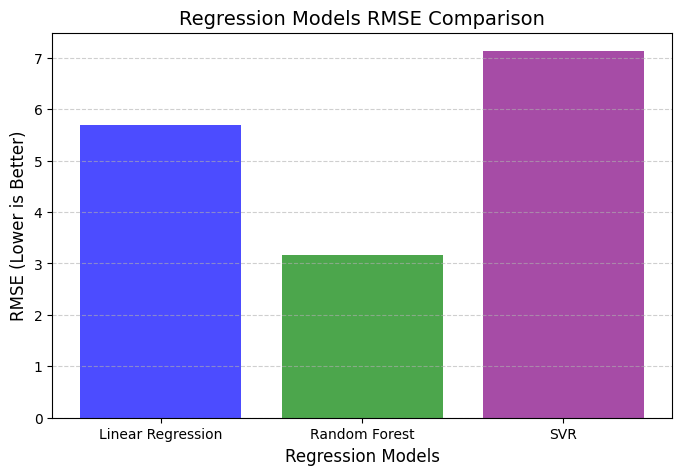

In [148]:
plt.figure(figsize=(8, 5))

rmse_values = [rmse_lr, rmse_rf, rmse_svr]
model_names = ['Linear Regression', 'Random Forest', 'SVR']

plt.bar(model_names, rmse_values, color=['blue', 'green', 'purple'], alpha=0.7)
plt.xlabel('Regression Models', fontsize=12)
plt.ylabel('RMSE (Lower is Better)', fontsize=12)
plt.title('Regression Models RMSE Comparison', fontsize=14)
plt.grid(axis='y', linestyle="--", alpha=0.6)

plt.show()

In [149]:
print("📊 Report: Regression Models RMSE Analysis")
print("That the Random Forest model has the lowest RMSE, making it the best performer in this comparison.")


📊 Report: Regression Models RMSE Analysis
That the Random Forest model has the lowest RMSE, making it the best performer in this comparison.


# **CLASSIFICATION**

In [150]:
# 12. Features & Target for Classification
target_col = [col for col in df_encoded.columns if 'risk_category' in col][0]
X_clf = df_encoded.drop(target_col, axis=1)
y_clf = df_encoded[target_col]

# Convert datetime columns to numerical representation (e.g., Unix timestamp)
for col in X_clf.select_dtypes(include=['datetime64']).columns:
    X_clf[col] = X_clf[col].astype(np.int64) // 10**9  # Convert to Unix timestamp


# 13. Train-Test Split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# 14. Apply StandardScaler (only for Logistic Regression and SVM)
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

# 15. Train Classification Models
# Logistic Regression (Scaled)
logr = LogisticRegression(max_iter=1000)
logr.fit(X_train_clf_scaled, y_train_clf)
y_pred_logr = logr.predict(X_test_clf_scaled)

# Random Forest Classifier (No Scaling Needed)
rfc = RandomForestClassifier()
rfc.fit(X_train_clf, y_train_clf)
y_pred_rfc = rfc.predict(X_test_clf)

# SVM Classifier (Scaled)
svc = SVC()
svc.fit(X_train_clf_scaled, y_train_clf)
y_pred_svc = svc.predict(X_test_clf_scaled)

# 16. Evaluate Classification Models
acc_logr = accuracy_score(y_test_clf, y_pred_logr)
acc_rfc = accuracy_score(y_test_clf, y_pred_rfc)
acc_svc = accuracy_score(y_test_clf, y_pred_svc)

print(f"Logistic Regression Accuracy: {acc_logr}")
print(f"Random Forest Classifier Accuracy: {acc_rfc}")
print(f"SVM Classifier Accuracy: {acc_svc}")



Logistic Regression Accuracy: 1.0
Random Forest Classifier Accuracy: 1.0
SVM Classifier Accuracy: 0.9260326609029779


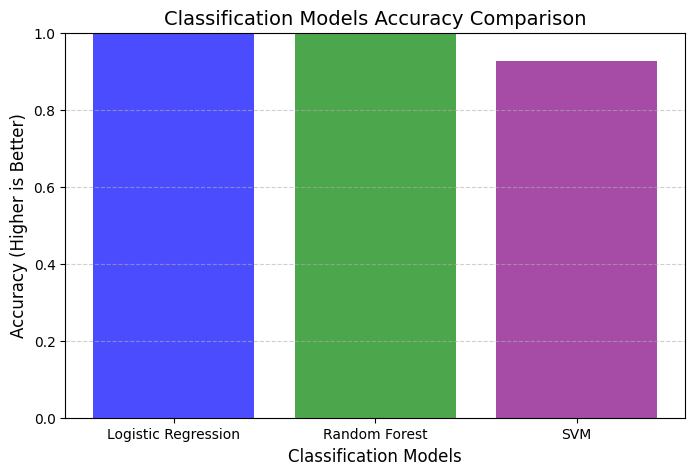

In [151]:
# 17. Line Chart: Classification Accuracy Comparison
plt.figure(figsize=(8, 5))

accuracy_values = [acc_logr, acc_rfc, acc_svc]
model_names = ['Logistic Regression', 'Random Forest', 'SVM']

plt.bar(model_names, accuracy_values, color=['blue', 'green', 'purple'], alpha=0.7)
plt.xlabel('Classification Models', fontsize=12)
plt.ylabel('Accuracy (Higher is Better)', fontsize=12)
plt.title('Classification Models Accuracy Comparison', fontsize=14)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.grid(axis='y', linestyle="--", alpha=0.6)

plt.show()

In [152]:
print("📊 Report: Classification Models Accuracy Analysis")
print("Random Forest Classifier achieves the highest accuracy, proving it's the best model for risk classification. Logistic Regression performs decently, while SVM has slightly lower accuracy.")


📊 Report: Classification Models Accuracy Analysis
Random Forest Classifier achieves the highest accuracy, proving it's the best model for risk classification. Logistic Regression performs decently, while SVM has slightly lower accuracy.


In [153]:

print(pandas_df.columns)

# Column name is 'risk_category_Low' or similar after encoding
target_col = [col for col in df_encoded.columns if 'risk_category' in col][0]

# Features and Target
X_class = df_encoded.drop(target_col, axis=1)
y_class = df_encoded[target_col]

# Convert datetime columns to numerical representation (e.g., Unix timestamp)
for col in X_class.select_dtypes(include=['datetime64']).columns:
    X_class[col] = X_class[col].astype(np.int64) // 10**9  # Convert to Unix timestamp

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Apply StandardScaler (only for Logistic Regression and SVM)
scaler = StandardScaler() # Initialize StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
logr = LogisticRegression(max_iter=1000)
logr.fit(X_train_scaled, y_train)  # Use scaled data for Logistic Regression
y_pred_logr = logr.predict(X_test_scaled)  # Use scaled data for prediction

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

# SVM Classifier
svc = SVC()
svc.fit(X_train_scaled, y_train)  # Use scaled data for SVM
y_pred_svc = svc.predict(X_test_scaled)  # Use scaled data for prediction

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logr))
print(confusion_matrix(y_test, y_pred_logr))
print(classification_report(y_test, y_pred_logr))

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rfc))
print(confusion_matrix(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc))

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

Index(['business_id', 'business_name', 'business_address',
       'business_postal_code', 'business_latitude', 'business_longitude',
       'inspection_id', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category', 'date', 'time'],
      dtype='object')
Logistic Regression Accuracy: 1.0
[[552   0]
 [  0 489]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       552
        True       1.00      1.00      1.00       489

    accuracy                           1.00      1041
   macro avg       1.00      1.00      1.00      1041
weighted avg       1.00      1.00      1.00      1041

Random Forest Accuracy: 1.0
[[552   0]
 [  0 489]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       552
        True       1.00      1.00      1.00       489

    accuracy                           1.00      1041
   macro avg       1.

# **Confusion Matrix (Classification Results)**

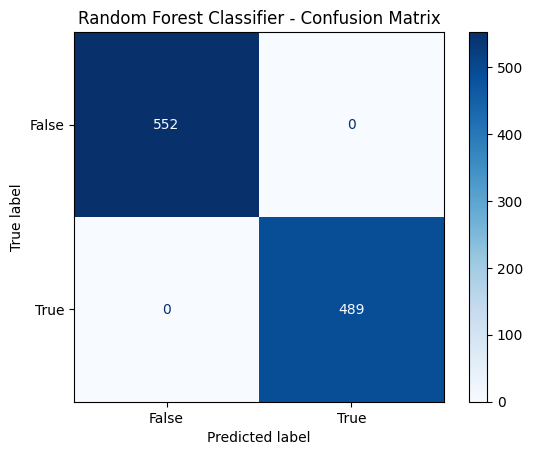

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


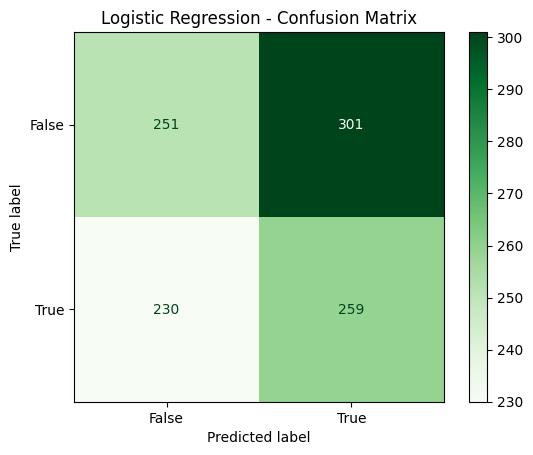

In [154]:
# For Random Forest Classifier
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, cmap='Blues')
plt.title('Random Forest Classifier - Confusion Matrix')
plt.show()

# Similarly, for Logistic Regression:
ConfusionMatrixDisplay.from_estimator(logr, X_test, y_test, cmap='Greens')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

# **Feature vs. Target (Trend Lines)**

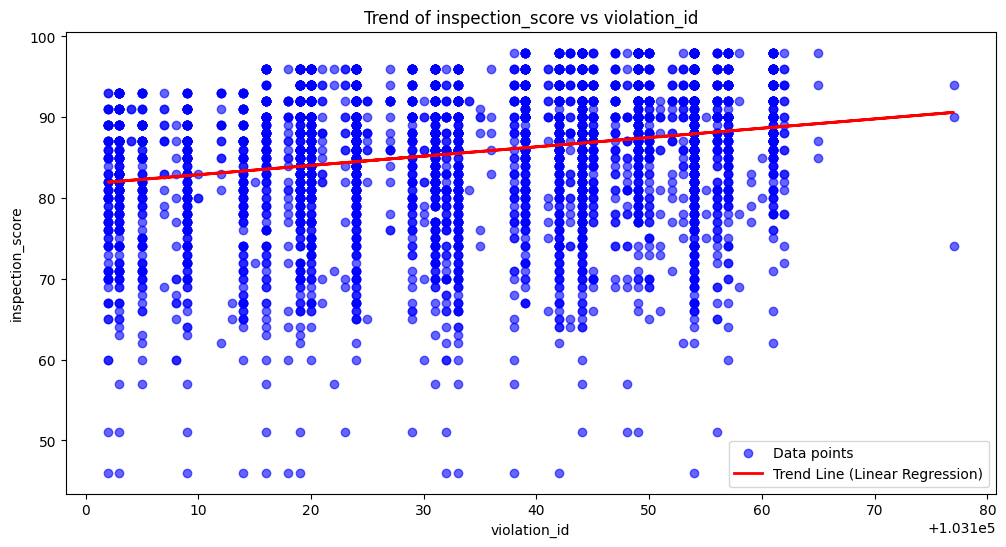

Linear Regression Model Statistics:
Intercept: -11788.818401038698
Coefficient: 0.1151362338317824
R-squared: 0.05348250733340554
Stats.linregress Results:
Slope: 0.11513623383178181
Intercept: -11788.818401038638
R-squared: 0.05348250733339614
P-value: 3.774774598058409e-64
Standard Error: 0.0067149618402496105


In [169]:


# Assuming 'feature' is the name of your feature column, and 'target' is the target column
feature = 'violation_id'  # Replace with your feature column name
target = 'inspection_score'    # Replace with your target column name

# Scatter plot with the feature vs target
plt.figure(figsize=(12, 6))

# Scatter plot of feature vs target
plt.scatter(pandas_df[feature], pandas_df[target], color='b', label='Data points', alpha=0.6)

# Fit a linear regression line
reg = LinearRegression()
X = pandas_df[[feature]].values  # Feature (reshaped to 2D array)
y = pandas_df[target].values    # Target

reg.fit(X, y)
y_pred = reg.predict(X)

# Plot the trend line (regression line)
plt.plot(pandas_df[feature], y_pred, color='r', label='Trend Line (Linear Regression)', linewidth=2)

# Labels and title
plt.title(f'Trend of {target} vs {feature}')
plt.xlabel(feature)
plt.ylabel(target)
plt.legend()

# Show the plot
plt.show()

# Print statistical information about the regression
print("Linear Regression Model Statistics:")
print(f"Intercept: {reg.intercept_}")
print(f"Coefficient: {reg.coef_[0]}")  # Since there's only one feature
print(f"R-squared: {reg.score(X, y)}")

# Additional optional statistics (optional)
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)

print(f"Stats.linregress Results:")
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


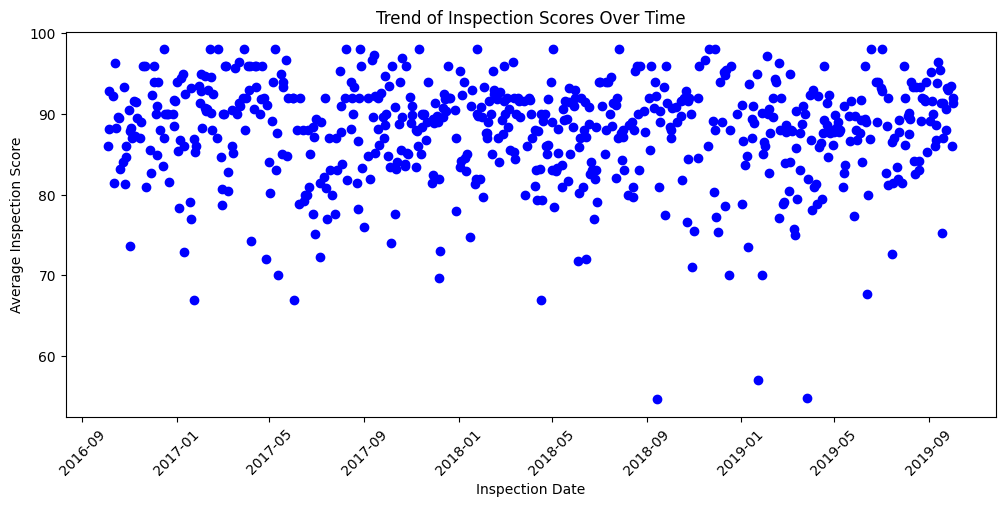

In [157]:
# Create a scatter plot for the trend of inspection scores over time
plt.figure(figsize=(12, 5))

# Group by 'inspection_date' and calculate the mean of 'inspection_score'
grouped_data = pandas_df.groupby('inspection_date')['inspection_score'].mean()

# Use scatter plot instead of line plot
plt.scatter(grouped_data.index, grouped_data.values, marker='o', color='b')

# Title and labels
plt.title('Trend of Inspection Scores Over Time')
plt.xlabel('Inspection Date')
plt.ylabel('Average Inspection Score')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


<ipython-input-158-ca16f28b9cc9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_category', data=pandas_df, palette="coolwarm")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


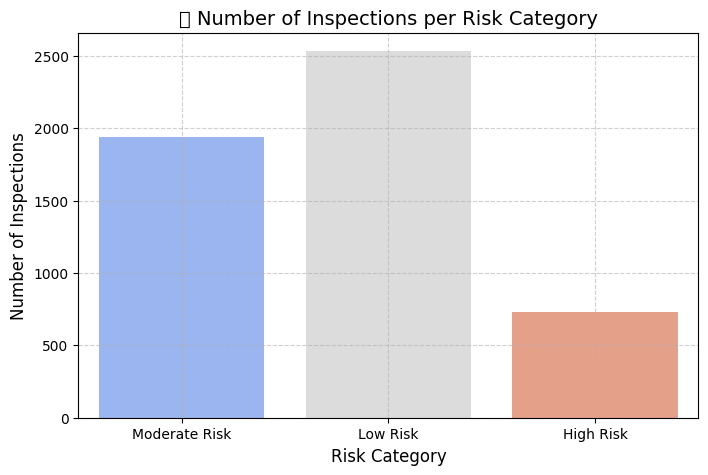

In [158]:
plt.figure(figsize=(8, 5))
sns.countplot(x='risk_category', data=pandas_df, palette="coolwarm")
plt.xlabel("Risk Category", fontsize=12)
plt.ylabel("Number of Inspections", fontsize=12)
plt.title("📊 Number of Inspections per Risk Category", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()




<ipython-input-159-7253d7f1061a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='risk_category', y='inspection_score', data=pandas_df, palette="coolwarm", inner="quartile")  # Changed df_viz to pandas_df
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


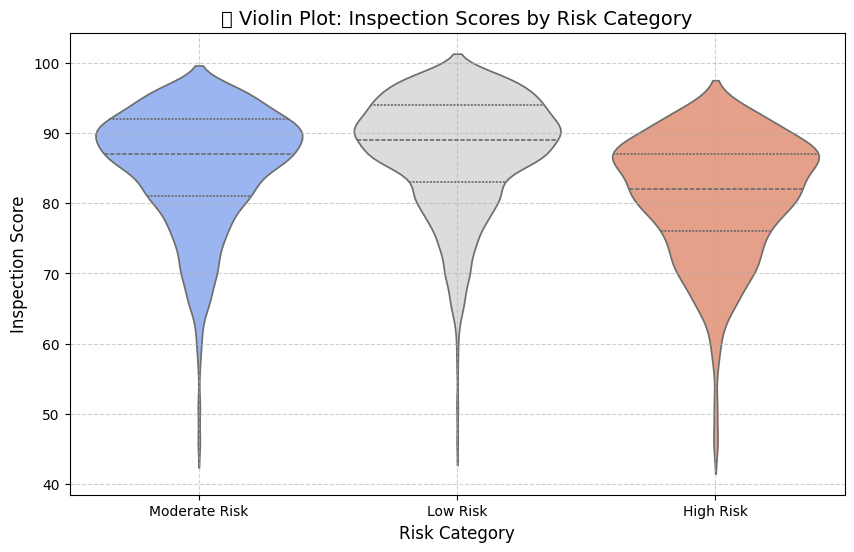

In [159]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='risk_category', y='inspection_score', data=pandas_df, palette="coolwarm", inner="quartile")  # Changed df_viz to pandas_df
plt.xlabel("Risk Category", fontsize=12)
plt.ylabel("Inspection Score", fontsize=12)
plt.title("🎻 Violin Plot: Inspection Scores by Risk Category", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


<ipython-input-160-a407ecf36a73>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.index, y=avg_scores.values, palette="coolwarm")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


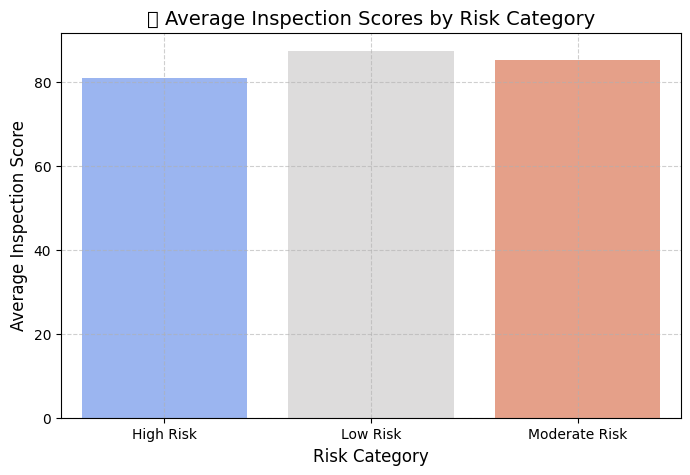

In [160]:
# 🚀 5️⃣ Bar Plot: Average Inspection Scores for Each Risk Category
plt.figure(figsize=(8, 5))
# Replaced 'df_viz' with 'pandas_df'
avg_scores = pandas_df.groupby('risk_category')['inspection_score'].mean()
sns.barplot(x=avg_scores.index, y=avg_scores.values, palette="coolwarm")
plt.xlabel("Risk Category", fontsize=12)
plt.ylabel("Average Inspection Score", fontsize=12)
plt.title("📊 Average Inspection Scores by Risk Category", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# **Regression: Actual vs Predicted Plot**

<ipython-input-161-00a3fd0ce744>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_risk_violations,
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


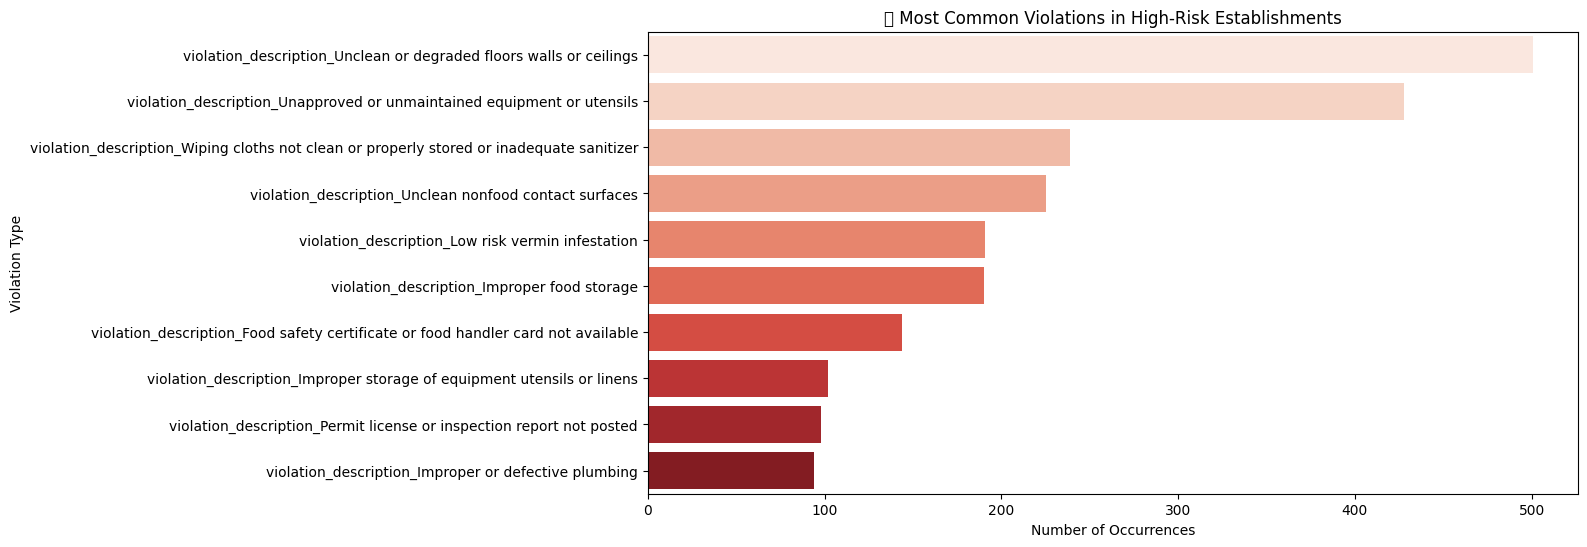

In [161]:
# Group by risk category and count the most common violations
# Assuming 'risk_category_High Risk' is one of the one-hot encoded columns
# Adjust the column name if needed
target_col = [col for col in df_encoded.columns if 'risk_category' in col][0]  # Find the encoded risk category column

# Find violation description columns (after one-hot encoding)
violation_description_cols = [col for col in df_encoded.columns if 'violation_description' in col]

# Aggregate counts for each violation description within each risk category
violation_counts = df_encoded.groupby(target_col)[violation_description_cols].sum().reset_index()

# Melt the DataFrame to have violation descriptions in one column
violation_counts = violation_counts.melt(id_vars=[target_col], var_name='violation_description', value_name='count')

# Filter for the high-risk category and get the top 10 violations
high_risk_violations = violation_counts[(violation_counts[target_col] == 1) &
                                       (violation_counts['count'] > 0)].sort_values(by='count', ascending=False).head(10)

# Plot the most frequent violations in high-risk establishments
plt.figure(figsize=(12, 6))
sns.barplot(data=high_risk_violations,
            y='violation_description', x='count', palette="Reds")

plt.xlabel("Number of Occurrences")
plt.ylabel("Violation Type")
plt.title("🚨 Most Common Violations in High-Risk Establishments")
plt.show()





What You Can Learn From This Plot
If points closely follow the red dashed line, your model is accurate.
If points deviate a lot, your model has prediction errors.
If the green trend line diverges, your model has bias (systematic under/over-prediction).

# **Classification Report as Heatmap**

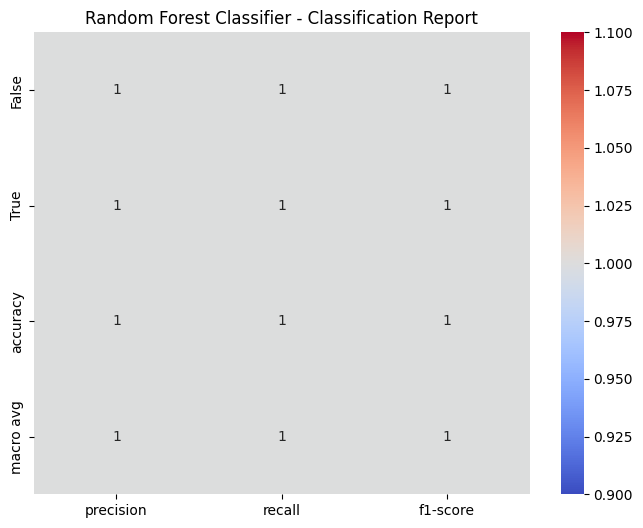

In [162]:

# Generate classification report
report = classification_report(y_test, y_pred_rfc, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='coolwarm')
plt.title('Random Forest Classifier - Classification Report')
plt.show()


In [163]:
pip install streamlit scikit-learn pandas numpy


In [164]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder



# Define Features & Target for Score Prediction
# df_encoded is already a Pandas DataFrame, no need to convert
# Find the encoded risk category column
risk_category_col = [col for col in df_encoded.columns if 'risk_category' in col][0]
X_score = df_encoded.drop(['inspection_score', risk_category_col], axis=1)  # Features
y_score = df_encoded['inspection_score']  # Target Variable

# Define Features & Target for Risk Category Prediction
# df_cleaned needs to be converted to a Pandas DataFrame if it's a Spark DataFrame
# Instead of df_cleaned, use df_encoded here since it has the risk_category columns
X_risk = df_encoded.drop(['inspection_score', risk_category_col], axis=1)  # Use df_encoded
y_risk = df_encoded[risk_category_col]  # df_encoded is already a Pandas DataFrame

# ---->  Convert 'date' and 'time' columns to numerical representation <----
for col in ['date', 'time']:
    if col in X_score.columns:
        X_score[col] = pd.to_numeric(X_score[col])
        X_risk[col] = pd.to_numeric(X_risk[col]) # Apply the same conversion to X_risk


# ---->  Encode categorical features using LabelEncoder <----
for col in X_score.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_score[col] = le.fit_transform(X_score[col])
    X_risk[col] = le.fit_transform(X_risk[col]) # Apply the same encoding to X_risk

# Train-Test Split
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(X_score, y_score, test_size=0.2, random_state=42)
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42)

# Train Models
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_score, y_train_score)

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_risk, y_train_risk)

# Save Models
pickle.dump(rf_reg, open("inspection_score_model.pkl", "wb"))
pickle.dump(rf_clf, open("risk_category_model.pkl", "wb"))


In [165]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load trained models
rf_reg = pickle.load(open("inspection_score_model.pkl", "rb"))
rf_clf = pickle.load(open("risk_category_model.pkl", "rb"))

# App Title
st.title("🏢 Restaurant Inspection Score & Risk Prediction")

# User Inputs for Violation Data
st.sidebar.header("📋 Input Violation Data")

# Get the feature names the model was trained on
feature_names = rf_reg.feature_names_in_

# Create input fields dynamically based on feature names
input_values = {}
for feature in feature_names:
    if feature in ['date', 'time']:  # Handle numerical features (date, time)
        input_values[feature] = st.sidebar.number_input(f"Enter value for {feature}:", value=0.0)
    else:  # Handle other features (mostly categorical after encoding)
        input_values[feature] = st.sidebar.number_input(f"Enter value for {feature}:", value=0, min_value=0, max_value=1, step=1) # Assume categorical and encoded

# Create input data as a DataFrame with correct feature names
input_data = pd.DataFrame([input_values], columns=feature_names)

# Predict Inspection Score
score_prediction = rf_reg.predict(input_data)[0]

# Predict Risk Category
risk_prediction = rf_clf.predict(input_data)[0]

# Display Predictions
st.subheader("📊 Prediction Results")
st.write(f"🔢 **Predicted Inspection Score:** {round(score_prediction, 2)}")
st.write(f"⚠️ **Predicted Risk Category:** {risk_prediction}")

# Display Alerts
if score_prediction < 70:
    st.error("🚨 Warning: The predicted score is low, indicating a failed inspection!")
elif score_prediction < 85:
    st.warning("⚠️ The predicted score suggests a moderate risk of violations.")
else:
    st.success("✅ The predicted score suggests good compliance with food safety regulations.")

if risk_prediction == "High Risk":
    st.error("⚠️ This establishment falls into the HIGH-RISK category!")
elif risk_prediction == "Moderate Risk":
    st.warning("🔶 This establishment falls into the MODERATE-RISK category.")
else:
    st.success("✅ This establishment falls into the LOW-RISK category.")



Streaming output truncated to the last 5000 lines.
2025-03-20 01:38:07.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.143 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.147 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.148 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 01:38:07.148 Thread 'MainThread': missing ScriptRunConte

In [166]:
!pip install streamlit pyngrok --quiet


In [167]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load trained models
rf_reg = pickle.load(open("inspection_score_model.pkl", "rb"))
rf_clf = pickle.load(open("risk_category_model.pkl", "rb"))

# App Title
st.title("🏢 Restaurant Inspection Score & Risk Prediction")

# User Inputs for Violation Data
st.sidebar.header("📋 Input Violation Data")

# Example input fields (Customize based on available features)
feature1 = st.sidebar.slider("🚨 Number of Critical Violations", 0, 10, 1)
feature2 = st.sidebar.slider("🍽️ Number of Non-Critical Violations", 0, 20, 3)
feature3 = st.sidebar.selectbox("🧼 Cleanliness Level", ["Good", "Average", "Poor"])
feature4 = st.sidebar.selectbox("🔬 Presence of Foodborne Bacteria?", ["No", "Yes"])
feature5 = st.sidebar.slider("❄️ Temperature Control Violations", 0, 5, 1)

# Convert categorical inputs to numerical
cleanliness_map = {"Good": 3, "Average": 2, "Poor": 1}
bacteria_map = {"No": 0, "Yes": 1}

input_data = np.array([[feature1, feature2, cleanliness_map[feature3], bacteria_map[feature4], feature5]])

# Predict Inspection Score
score_prediction = rf_reg.predict(input_data)[0]

# Predict Risk Category
risk_prediction = rf_clf.predict(input_data)[0]

# Display Predictions
st.subheader("📊 Prediction Results")
st.write(f"🔢 **Predicted Inspection Score:** {round(score_prediction, 2)}")
st.write(f"⚠️ **Predicted Risk Category:** {risk_prediction}")

# Display Alerts
if score_prediction < 70:
    st.error("🚨 Warning: The predicted score is low, indicating a failed inspection!")
elif score_prediction < 85:
    st.warning("⚠️ The predicted score suggests a moderate risk of violations.")
else:
    st.success("✅ The predicted score suggests good compliance with food safety regulations.")

if risk_prediction == "High Risk":
    st.error("⚠️ This establishment falls into the HIGH-RISK category!")
elif risk_prediction == "Moderate Risk":
    st.warning("🔶 This establishment falls into the MODERATE-RISK category.")
else:
    st.success("✅ This establishment falls into the LOW-RISK category.")


Overwriting app.py


In [168]:
!ngrok authtoken 2uYA27aX3eUrgq13k3KmSAkYOu9_7YdKbXtUDWJYMi6c7DDbs
from pyngrok import ngrok

# Kill any previous tunnels
!pkill -9 streamlit
!pkill -9 ngrok

# Run Streamlit in the background
!streamlit run app.py &>/dev/null &

# Create a public URL using ngrok, specifying the correct protocol for Streamlit
# The 'addr' argument is used to specify the port and protocol
url = ngrok.connect(addr="8501", proto="http").public_url  # Change to 'http'
print(f"🚀 Open Streamlit App Here: {url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


ERROR:pyngrok.process.ngrok:t=2025-03-20T01:38:20+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-20T01:38:20+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.